# Wikipedia data extraction: Spotify streaming records

Use requests and beautiful soup to download and parse spotify streaming records from Wikipedia.

## 1. Notebook set-up

In [1]:
# Standard libraries
import sqlite3
from pathlib import Path

# External libraries 
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from helper_functions import extract_table_data

In [2]:
# Target URL
url = 'https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records'

# Web browser-like request headers
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36' +
        '(KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
}

## 2. Download HTML

In [3]:
# Catch any errors with try-except block
try:
    # Fetch the book page
    response = requests.get(url, headers=headers, timeout=15)
    response.raise_for_status()

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

except requests.exceptions.RequestException as e:
    print(f'Caught exception from requests: {e}')
    soup = None

## 3. Transform the HTML

### 3.1. Get the table rows

In [4]:
tables = soup.find_all('table')
most_streamed_table = tables[0]
column_names = most_streamed_table.find_all('tr')[0]

### 3.2. Get the column names

In [5]:
# Get just the header row from the table
table_header = most_streamed_table.find_all('tr')[0]

# Loop on the th tags to collect the column names
column_names = []

for column in table_header.find_all('th'):
    column_names.append(column.get_text().strip())

print(f'Column names: {column_names}')

Column names: ['Rank', 'Song', 'Artist(s)', 'Streams(billions)', 'Release date', 'Ref.']



### 3.3. Get the data from the table body

In [6]:
# List
results = extract_table_data(most_streamed_table)

### 3.4. Convert to Pandas DataFrame

In [7]:
results_df = pd.DataFrame(results, columns=column_names)
results_df.head()

,Rank,Song,Artist(s),Streams(billions),Release date,Ref.
0,1,Blinding Lights,The Weeknd,4.961,29 November 2019,[2]
1,2,Shape of You,Ed Sheeran,4.490,6 January 2017,[3]
2,3,Starboy,The Weeknd and Daft Punk,4.024,21 September 2016,[4]
3,4,Someone You Loved,Lewis Capaldi,4.002,8 November 2018,[5]
4,5,As It Was,Harry Styles,3.992,1 April 2022,[6]


## 4. Process the DataFrame

### 4.1. Remove unnecessary columns

In [8]:
# Drop the Ref. columns - we could parse the references at the end of the page 
# and fill in the source, but that information is not needed to complete the 
# assignment
results_df.drop('Ref.', axis=1, inplace=True)
results_df.head()

,Rank,Song,Artist(s),Streams(billions),Release date
0,1,Blinding Lights,The Weeknd,4.961,29 November 2019
1,2,Shape of You,Ed Sheeran,4.490,6 January 2017
2,3,Starboy,The Weeknd and Daft Punk,4.024,21 September 2016
3,4,Someone You Loved,Lewis Capaldi,4.002,8 November 2018
4,5,As It Was,Harry Styles,3.992,1 April 2022


### 4.2. Set column data types

In [9]:
# Set types for number and string columns
dtypes = {
    'Rank': float,
    'Song': 'string',
    'Artist(s)': 'string',
    'Streams(billions)': float
}

results_df = results_df.astype(dtypes)

# Convert 'Release date' to datetime format
results_df['Release date'] = pd.to_datetime(results_df['Release date'])

results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Rank               100 non-null    float64       
 1   Song               100 non-null    string        
 2   Artist(s)          100 non-null    string        
 3   Streams(billions)  100 non-null    float64       
 4   Release date       100 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), string(2)
memory usage: 4.1 KB


## 5. Store the data in SQLite

In [10]:
# Create a data directory, if it doesn't exist
Path('../data').mkdir(exist_ok=True, parents=True)

# Create and connect to SQLite database
conn = sqlite3.connect('../data/spotify.db')

# Create a table and insert the top songs DataFrame
results_df.to_sql('top_songs', conn, if_exists='replace', index=False)

# Close the connection
conn.close()

## 6. Visualize the data

### 6.1. Stream count distribution

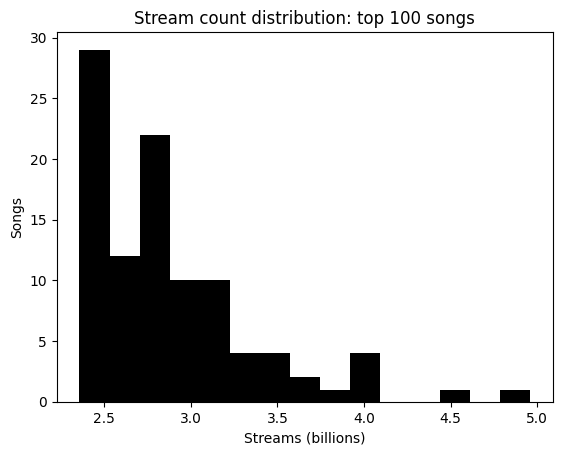

In [11]:
plt.title('Stream count distribution: top 100 songs')
plt.hist(results_df['Streams(billions)'], bins=15, color='black')
plt.xlabel('Streams (billions)')
plt.ylabel('Songs')
plt.show()

This histogram shows how the top 100 songs are distributed by their total number of streams (in billions). It helps visualize whether most songs have similar stream counts or if a few songs dominate the streaming numbers.

**Observations:**
- The distribution is right-skewed, with most songs clustered at lower stream counts.
- Only a handful of songs have exceptionally high stream numbers, indicating a few outliers dominate the top of the chart.

### 6.2. Stream count by release date

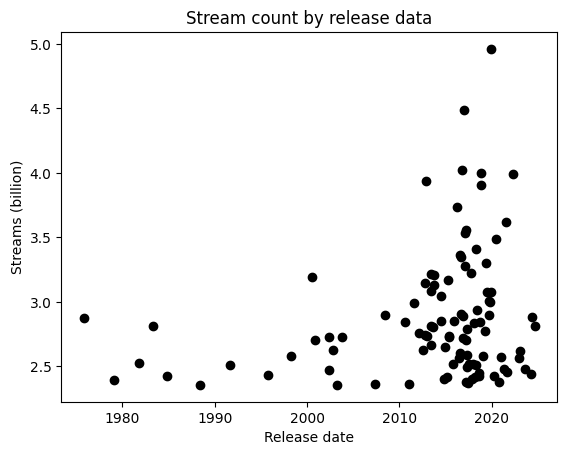

In [12]:
plt.title('Stream count by release data')
plt.scatter(results_df['Release date'], results_df['Streams(billions)'], color='black')
plt.xlabel('Release date')
plt.ylabel('Streams (billion)')
plt.show()

This scatter plot displays the relationship between a song's release date and its total number of streams. It helps identify trends in streaming popularity over time and whether newer or older songs tend to have more streams.

**Observations:**
- Many of the most-streamed songs are relatively recent releases, suggesting newer songs tend to accumulate streams quickly.
- There are a few older songs with high stream counts, but the majority of top songs are from the last decade.

### 6.3. Top songs per year

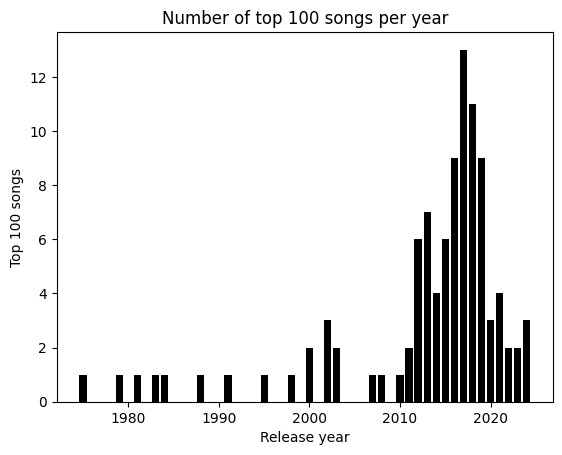

In [13]:
yearly_df = results_df['Release date'].dt.year.value_counts()

plt.title('Number of top 100 songs per year')
plt.bar(yearly_df.index, yearly_df, color='black')
plt.xlabel('Release year')
plt.ylabel('Top 100 songs')
plt.show()

This bar chart shows the number of top 100 songs released each year. It highlights which years were particularly prolific for hit songs and can reveal trends or shifts in music popularity over time.

**Observations:**
- Certain years stand out with a higher number of top songs, possibly reflecting trends or changes in the music industry.
- There may be clusters of years with more hits, indicating periods of increased musical output or popularity.

### 6.4. Top songs by month

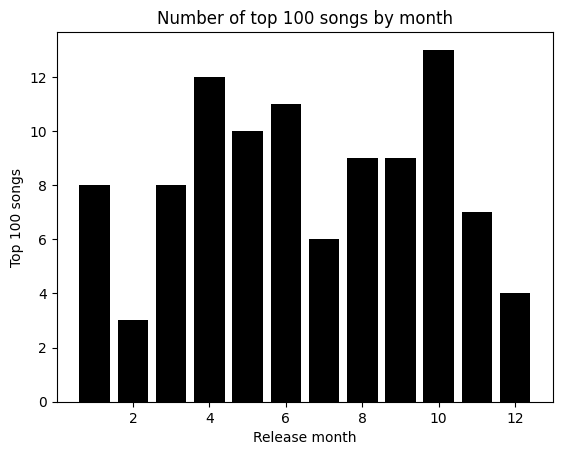

In [14]:
monthly_df = results_df['Release date'].dt.month.value_counts()

plt.title('Number of top 100 songs by month')
plt.bar(monthly_df.index, monthly_df, color='black')
plt.xlabel('Release month')
plt.ylabel('Top 100 songs')
plt.show()

This bar chart displays the distribution of top 100 songs by their release month. It can reveal seasonal trends or patterns in when hit songs are most commonly released.

**Observations:**
- Some months may have noticeably more top releases, suggesting possible industry strategies or seasonal effects.
- There is no strong evidence of a single month dominating, but certain months could be slightly more popular for releases.

### 6.5. Most popular artists

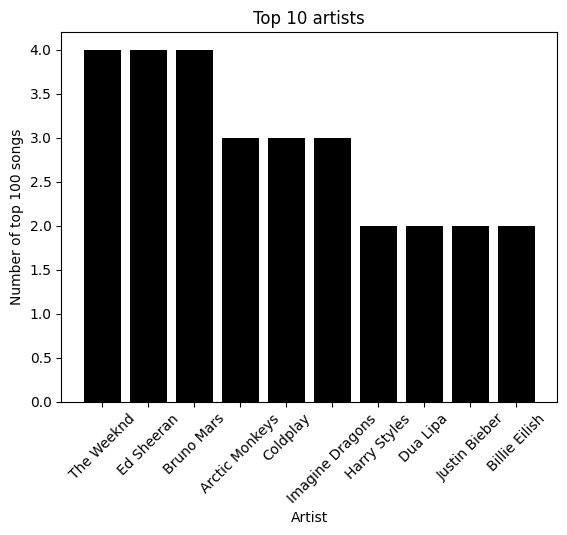

In [15]:
top_artists_df = results_df['Artist(s)'].value_counts().nlargest(10)

plt.title('Top 10 artists')
plt.bar(top_artists_df.index, top_artists_df, color='black')
plt.xlabel('Artist')
plt.ylabel('Number of top 100 songs')
plt.xticks(rotation=45)
plt.show()

This bar chart highlights the top 10 artists with the most songs in the top 100. It shows which artists have achieved repeated success on Spotify's most-streamed list.

**Observations:**
- A small number of artists have multiple entries, indicating consistent popularity or strong fan bases.
- The majority of artists appear only once, showing that breaking into the top 100 is a significant achievement.